In [139]:
### Imports and environment
# Imports
import os
import io
from dotenv import load_dotenv
# import streamlit as st
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.colormaps as mcolormaps
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
import requests

### Set static paths
svc_hiit_dash_workout = '/Users/curtismcginity/stanford/research/proj/HIITvsMICT/secrets/gcp/hiit-vs-mict-50dbc00f450b.json'

### Set gdrive folders
fid_root = '0AB6End4Uf7P-Uk9PVA'
fid_workout = '1a9Bmg89_9m9BaYLsLw52PS_m07FQ7CtZ'
fid_sl_fitbit = '11rL8hgBPvlGUQAyq_f0HYjsrbCRNtizQ'

### Load env variables
load_dotenv()

True

In [141]:
def setup_drive():
    SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

    creds = Credentials.from_service_account_file(svc_hiit_dash_workout, scopes=SCOPES)
    service = build('drive', 'v3', credentials=creds)
    return service

def load_data_from_drive(_drive_service, file_id):
    request = _drive_service.files().get_media(fileId=file_id)
    io_buffer = io.BytesIO()
    downloader = MediaIoBaseDownload(io_buffer, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
    io_buffer.seek(0)
    df = pd.read_csv(io_buffer, parse_dates=['_realtime','_time'])
    # df = df[df['value'] >= 0.8 * df['target_hr_45']]
    return df


def preload_data_from_drive(parent_id):
    drive_service = setup_drive()
    preloaded_data = {}
    
    # Get list of files in the specified folder
    response = drive_service.files().list(corpora='drive', 
                                          driveId=fid_root,
                                          q=f"'{parent_id}' in parents",
                                          includeItemsFromAllDrives=True, 
                                          supportsAllDrives=True).execute()
    # Iterate over each file and load its data
    for file in response.get('files', []):
        if file.get('name').startswith("workout"):
            continue
        file_id = file['id']
        df = load_data_from_drive(drive_service, file_id)
        preloaded_data[file_id] = df
    
    return preloaded_data

def preload_data_from_drive2(parent_id):
    drive_service = setup_drive()
    preloaded_data = {}
    
    # Get list of files in the specified folder
    response = drive_service.files().list(corpora='drive', 
                                          driveId=fid_root,
                                          q=f"'{parent_id}' in parents",
                                          includeItemsFromAllDrives=True, 
                                          supportsAllDrives=True).execute()
    # Iterate over each file and load its data
    for file in response.get('files', []):
        if file.get('name').startswith("q"):
            continue
        file_id = file['id']
        df = load_data_from_drive(drive_service, file_id)
        preloaded_data[file_id] = df
    
    return preloaded_data

def get_file_ids_from_dir(parent_id):
    drive_service = setup_drive()
    results = drive_service.files().list(
        corpora='drive',
        driveId=fid_root,
        q=f"'{parent_id}' in parents",
        includeItemsFromAllDrives=True,
        supportsAllDrives=True
    ).execute()
    files = results.get('files', [])
    if not files:
        raise Exception(f"Folder {parent_id} has no files!")
    # id_name = [{x['name'] : x['id']} for x in files]
    id_name = {}
    for x in files:
        id_name[x['name']] = x['id']
    return id_name

def read_redcap_report(api_url, api_key, report_id):
    """
    Reads a specific report from REDCap into a pandas DataFrame.

    :param api_url: URL to the REDCap API endpoint.
    :param api_key: API key for authentication.
    :param report_id: ID of the report to be fetched.
    :return: DataFrame containing the report data or None if an error occurs.
    """

    # Define the payload for the REDCap API request
    data = {
        'token': api_key,
        'content': 'report',
        'format': 'csv',
        'report_id': report_id,
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'returnFormat': 'csv'
    }

    # Make the POST request to the REDCap API
    response = requests.post(api_url, data=data)

    # Check if the request was successful
    if response.status_code != 200:
        print(f"Error fetching data from REDCap: {response.text}")
        return None

    # Convert the CSV response to a pandas DataFrame
    try:
        df = pd.read_csv(io.StringIO(response.text))
        return df
    except pd.errors.ParserError:
        print("Error parsing REDCap response as CSV")
        return None

In [179]:
sl_fids = get_file_ids_from_dir(fid_sl_fitbit)


{'080_qtz1b19331948298967664_sl_WearableFitbit_Fitbit.csv': '13muA-3fIBBSzwLVShpvdX0ltHAPAmP6L',
 '075_qtz1b19516699726434684_sl_WearableFitbit_Fitbit.csv': '13jSF3hbUB2jPkBUlBk6tlifw8QMPn7vm',
 '071_qtz1b19649447249479579_sl_WearableFitbit_Fitbit.csv': '13joHVE_8hvXJ_3b1yZrm7Egtc-YQic9E',
 '070_qtz1b14637549187739211_sl_WearableFitbit_Fitbit.csv': '13daNioDkgTlvCOt-007DmAuAyGK8mjPx',
 '056_qtz1b12687913936119614_sl_WearableFitbit_Fitbit.csv': '13fAcohWSIH_oSwCdmbycg9BQhULF4QKj',
 '072_qtz1b19779165843537516_sl_WearableFitbit_Fitbit.csv': '13fUImyOWDT30qf0yEYLfy2fhul-JaoVC',
 '060_qtz1b13779232687428538_sl_WearableFitbit_Fitbit.csv': '13FJr8kOHDfTE_Lw95KxwppacgOo67aF7',
 'qtz1b16367913677313525_sl_WearableFitbit_Fitbit.csv': '13WeBQCFLUp9DnHfmLJje5A21sMmLtads',
 '036_qtz1b18341388618579643_sl_WearableFitbit_Fitbit.csv': '12kP73_8thegnv3xL_1wTwgIUqpSX10AQ',
 '026_qtz1b12285682268619722_sl_WearableFitbit_Fitbit.csv': '12vtu57mMei48POeHX4SVFz0l3EXnb6Am',
 '021_qtz1b16327775253853113_sl_We

In [14]:
# Authenticate with Google Drive using service account credentials
drive_service = setup_drive()

In [15]:
# Load all workouts for each PPT
workouts_dfs = preload_data_from_drive(fid_workout)

In [146]:
# Load metadata from REDCap report
dfppt = read_redcap_report(os.getenv('api_url'), os.getenv('api_key_curtis'), os.getenv('ppt_meta_master_id'))
# dfppt.head(20)

In [147]:
# Get file name to file id mapping
fname_fid_dict = get_file_ids_from_dir(fid_workout)

In [169]:
def preprocess(df):
    # Ensure datetime format
    df['_realtime'] = pd.to_datetime(df['_realtime'])

    # Ensure ID formatting
    df['wk_id'] = df['wk_id'].apply(lambda x: f'{x:02}')

    # Focus on polar data
    df = df.loc[df['device'] == "Polar"]
    

    # Compute workout start time
    df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')

    # Calculate a new field _wotime as difference in a resolution (e.g., minutes) from _wotime_base
    df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes

    # Give a time 

    return df

def plot_workouts(df):
    # ppt = df.loc[0,'ppt_id']
    ppt = df['ppt_id'].apply(lambda x: f'{x:03}')
    ppt = ppt.iloc[0]
    workouts = df.groupby(['wk_id', 'wo_id'])

    # Setup the color map
    n_colors = workouts.ngroups
    cmap = plt.get_cmap('viridis', n_colors) 

    plt.figure(figsize=(10, 6))

    for i, ((wk_id, wo_id), wo) in enumerate(workouts):
        plt.plot(wo['_wotime'], wo['value'], label=f'Week {wk_id}, Workout {wo_id}', color=cmap(i), alpha=0.8)
    
    plt.xlabel('Workout Duration (Minutes)')
    plt.ylabel('HR')
    plt.title(f'{ppt}: Workout Performance Over Time')
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.) 
    # plt.legend() 
    plt.tight_layout()
    plt.show()

def plot_workouts_2(df):
    
    # Determine unique combinations of wk_id and wo_id
    workout_groups = df.groupby(['wk_id', 'wo_id'])
    
    # Setup the color map
    n_colors = workout_groups.ngroups
    cmap = plt.get_cmap('viridis', n_colors) 
    
    plt.figure(figsize=(10, 6))
    
    # Plot each group
    for i, ((wk_id, wo_id), group) in enumerate(workout_groups):
        # Convert '_wotime' to a proper format for plotting (e.g., hours or minutes)
        wotime_hours = group['_wotime'].dt.total_seconds() / 3600.0
        plt.plot(wotime_hours, group['value'], label=f'Week {wk_id}, Workout {wo_id}',
                 color=cmap(i), alpha=0.8)
    
    plt.xlabel('Time since workout start (hours)')
    plt.ylabel('Value')
    plt.title('Workout Time Series')
    plt.legend(fontsize='small', loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_workouts_corrected(df):
    # Assuming 'df' is your DataFrame and it already includes the '_wotime' column correctly calculated

    # Convert '_wotime' to timedelta if it's not already
    if not pd.api.types.is_timedelta64_dtype(df['_wotime']):
        df['_wotime'] = pd.to_timedelta(df['_wotime'])
    
    # Prepare the colormap
    unique_workouts = df[['wk_id', 'wo_id']].drop_duplicates().shape[0]
    cmap = plt.get_cmap('viridis', unique_workouts)  # Corrected colormap access

    # Group by 'wk_id' and 'wo_id'
    workout_groups = df.groupby(['wk_id', 'wo_id'])

    # Plot settings
    plt.figure(figsize=(12, 8))

    for i, ((wk_id, wo_id), group) in enumerate(workout_groups):
        # Ensure '_wotime' is treated as timedelta for plotting
        wotime_hours = group['_wotime'].dt.total_seconds() / 3600.0
        plt.plot(wotime_hours, group['value'], label=f'Week {wk_id}, Workout {wo_id}',
                 color=cmap(i), alpha=0.8)

    plt.xlabel('Time since workout start (hours)')
    plt.ylabel('Value')
    plt.title('Workout Values Over Time')
    plt.legend(fontsize='small', loc='upper left')
    plt.show()

def plot_data_aggregated(df):
    # First, ensure '_wotime' is in the correct timedelta format if it represents elapsed time
    if not pd.api.types.is_timedelta64_dtype(df['_wotime']):
        df['_wotime'] = pd.to_timedelta(df['_wotime'])
    
    # Convert '_wotime' to minutes for plotting
    df['_wotime_minutes'] = df['_wotime'].dt.total_seconds() / 60.0

    # Aggregate the data
    aggregated_df = (
        df.groupby(['wk_id', 'wo_id'], as_index=False)
        .agg(value_med=('value', 'median'), _wotime_median=('_wotime_minutes', 'median'))
    )

    plt.figure(figsize=(10, 6))

    # Plot each group based on the aggregated data
    for _, row in aggregated_df.iterrows():
        # Plotting the median value against the median '_wotime' might not make sense unless '_wotime' is categorical or pre-binned
        plt.plot(row['_wotime_median'], row['value_med'], label=f'Week {row["wk_id"]}, Workout {row["wo_id"]}', alpha=0.8)

    plt.xlabel('Median Minutes from Workout Start')
    plt.ylabel('Median Value')
    plt.title('Workout Performance Across Time (Median Aggregated)')
    plt.legend(fontsize='small', loc='upper left')
    plt.show()

def plot_data_aggregated2(df):
    # Assuming '_wotime' is already in a suitable numeric format representing minutes or similar from workout start
    # If not, convert '_wotime' to a numeric format that represents the elapsed time in minutes or a suitable time unit

    # Aggregate the data to find the median 'value' for each 'wk_id', 'wo_id', and '_wotime'
    # Note: This approach assumes '_wotime' can be used directly for aggregation. If '_wotime' needs binning, additional steps are required
    aggregated_df = (
        df.groupby(['wk_id', 'wo_id', '_wotime'], as_index=False)
        .agg(value_med=('value', 'median'))
    )

    # Prepare the colormap
    unique_workouts = df[['wk_id', 'wo_id']].drop_duplicates().shape[0]
    cmap = plt.get_cmap('viridis', unique_workouts)  # Corrected colormap access

    # Plotting
    plt.figure(figsize=(10, 6))

    # Since we might lose the continuity in '_wotime' by taking the median, we consider each unique group for plotting
    agg_groups = aggregated_df.groupby(['wk_id', 'wo_id'])
    for i,((wk_id, wo_id), group) in enumerate(agg_groups):
        plt.plot(group['_wotime'], group['value_med'], label=f'Week {wk_id}, Workout {wo_id}', color=cmap(i), alpha=0.8)

    plt.xlabel('Minutes from Workout Start')
    plt.ylabel('Median Value')
    plt.title('Workout Performance Across Time (Median Aggregated)')
    plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)    
    plt.tight_layout()
    plt.show()

In [177]:
dftest = workouts_dfs[fname_fid_dict['018_qtz1b19261322566215748_workout_allevents.csv']]
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122809 entries, 0 to 122808
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   value            122809 non-null  float64       
 1   _realtime        122809 non-null  datetime64[ns]
 2   _time            122809 non-null  datetime64[ns]
 3   ppt_id           122809 non-null  int64         
 4   wk_id            122809 non-null  object        
 5   wo_id            122809 non-null  int64         
 6   datatype         122809 non-null  object        
 7   sourcetype       122809 non-null  object        
 8   device           122809 non-null  object        
 9   myphd_id         122809 non-null  object        
 10  _wotime_base     122809 non-null  datetime64[ns]
 11  _wotime          122809 non-null  float64       
 12  _wotime_minutes  122809 non-null  float64       
dtypes: datetime64[ns](3), float64(3), int64(2), object(5)
memory usage: 12.2+ 

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/2359944355.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/2359944355.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


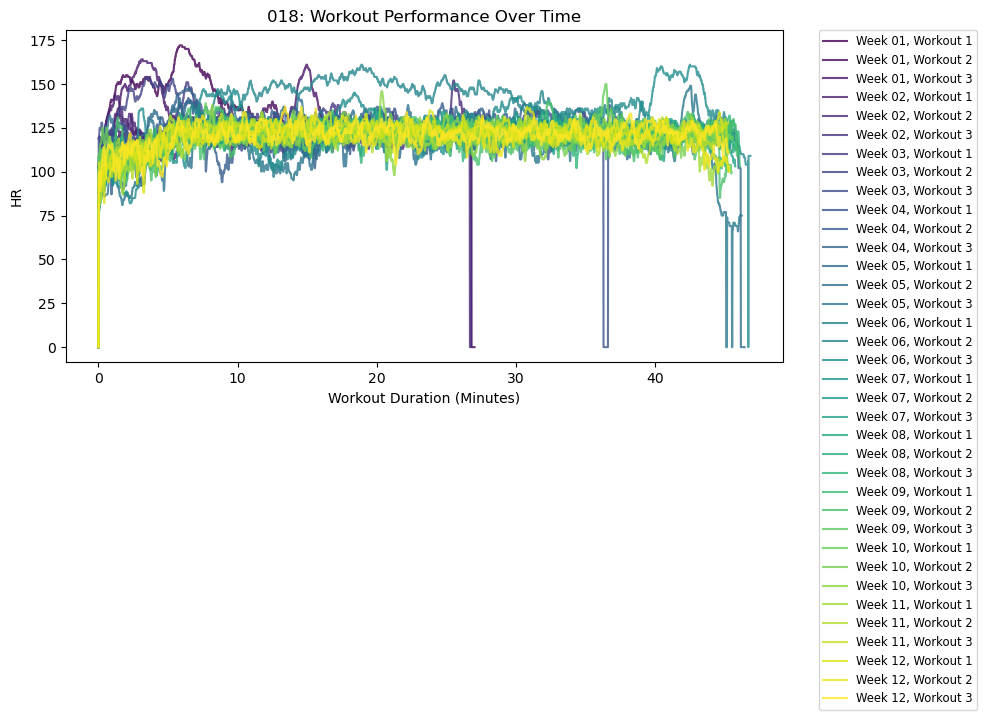

In [167]:
dftest_wotime = preprocess(dftest)
plot_workouts(dftest_wotime)

In [ ]:
plot_workouts2(dftest_wotime)

In [ ]:
dfthing = (dftest
    .groupby(['wk_id', 'wo_id'])
    .agg(value_med=('value','median'))
    .reset_index()
    )
dfthing

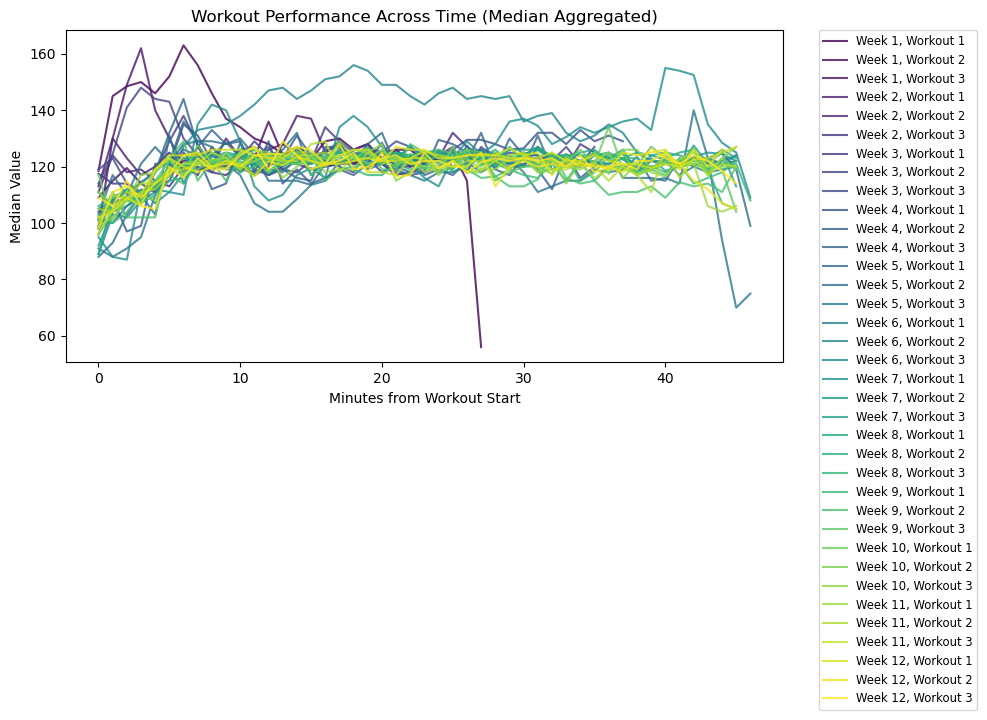

In [74]:
plot_data_aggregated2(dftest)

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


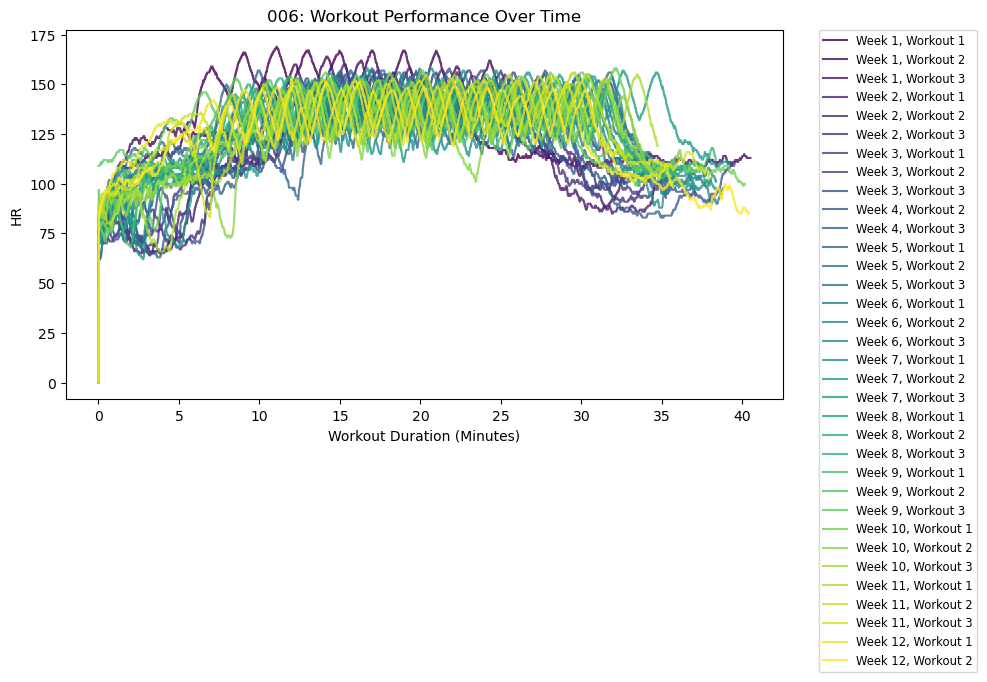

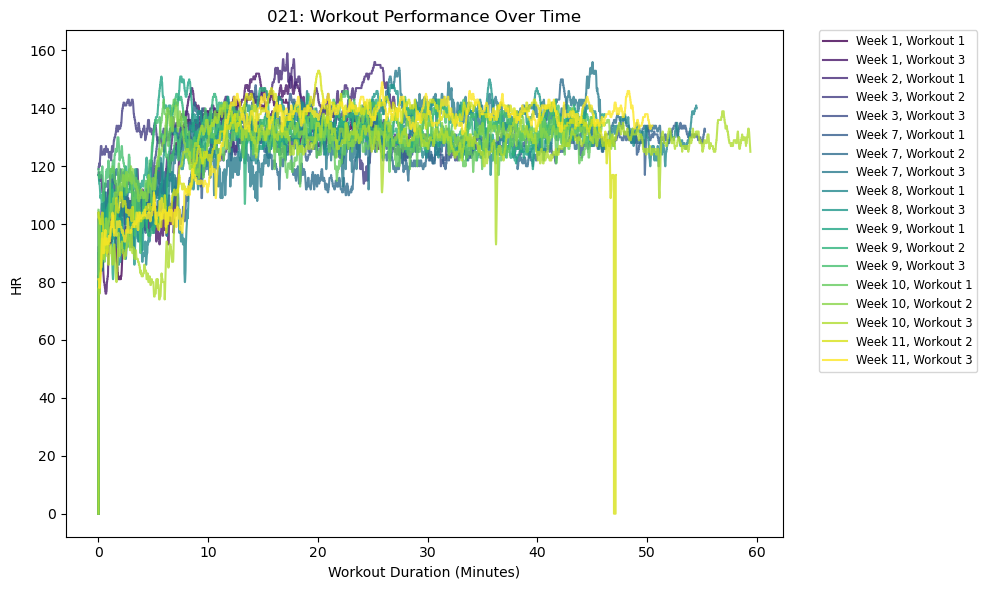

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


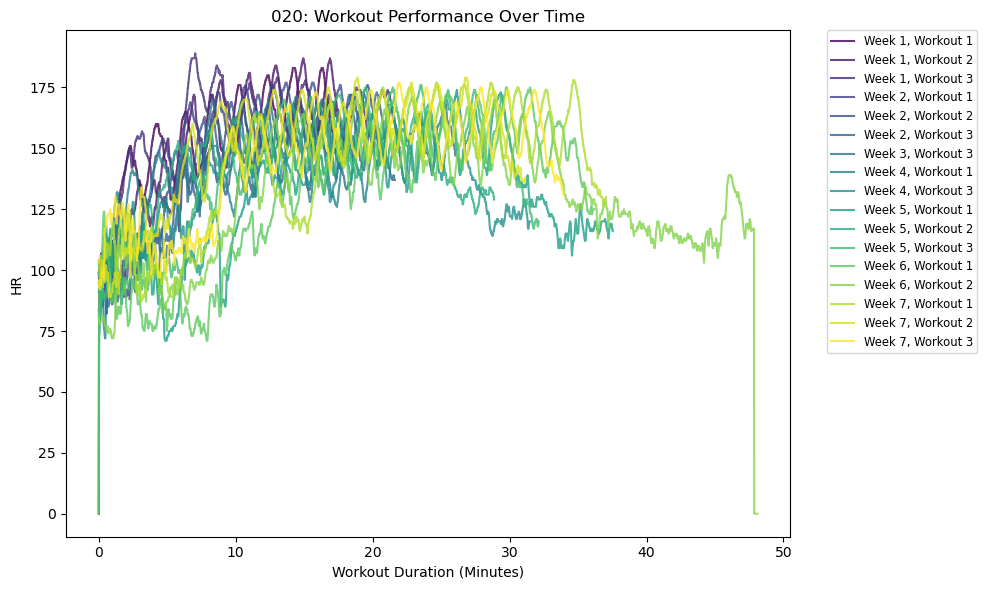

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


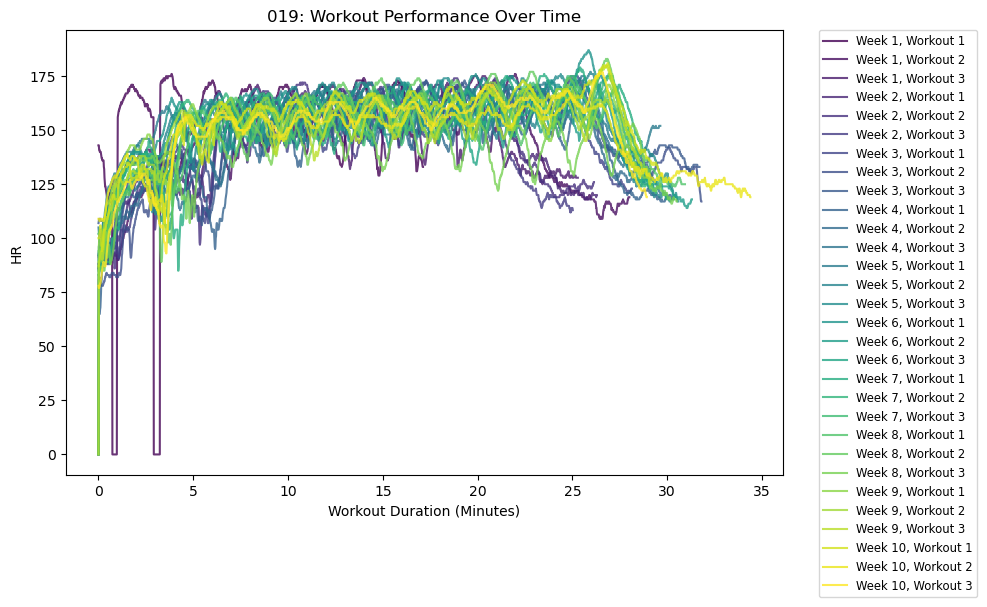

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


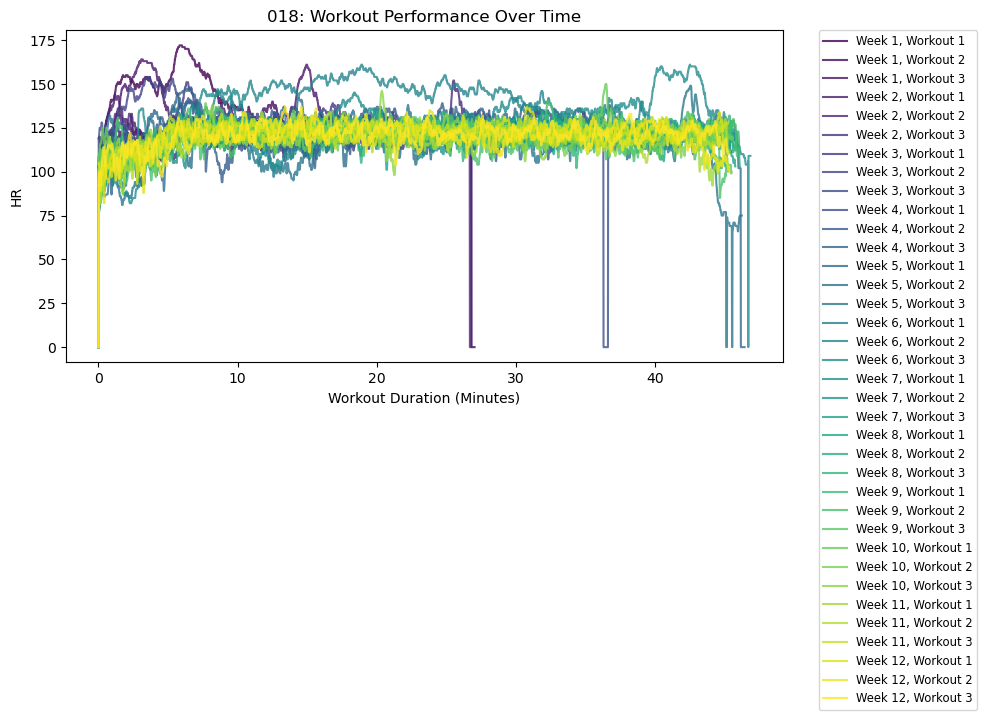

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


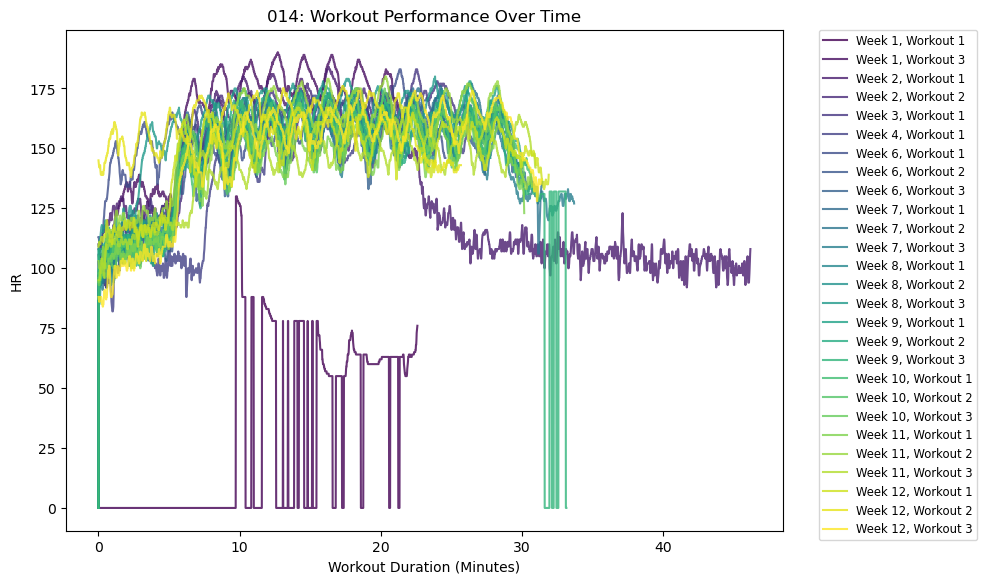

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


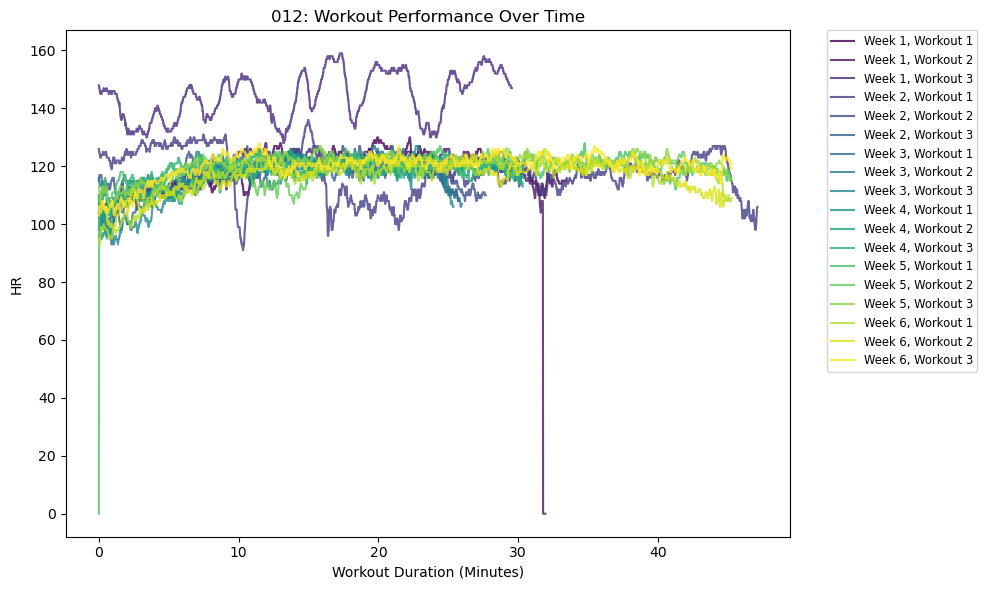

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/224543495.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df['_realtime'] - df['_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes


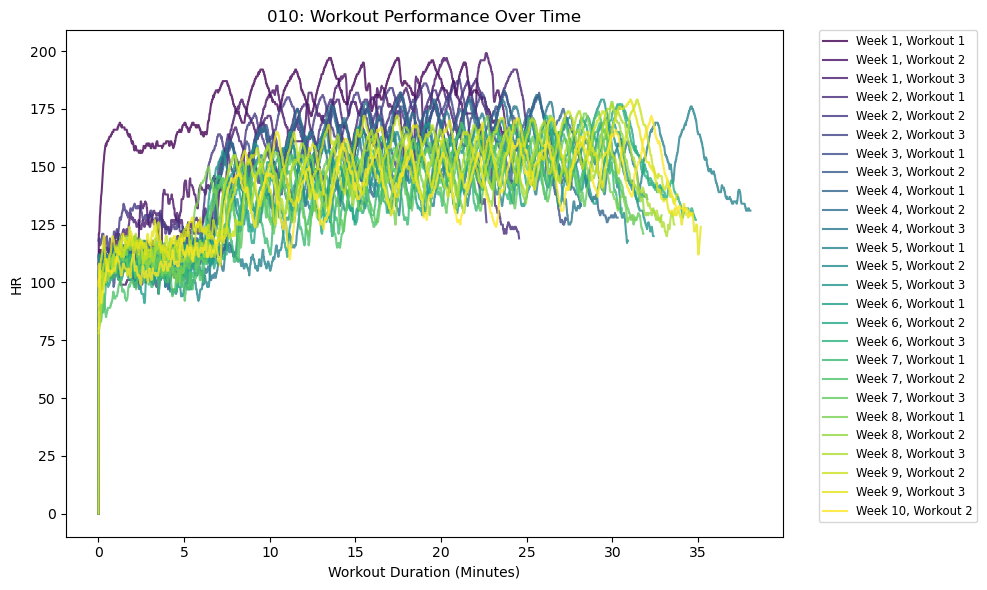

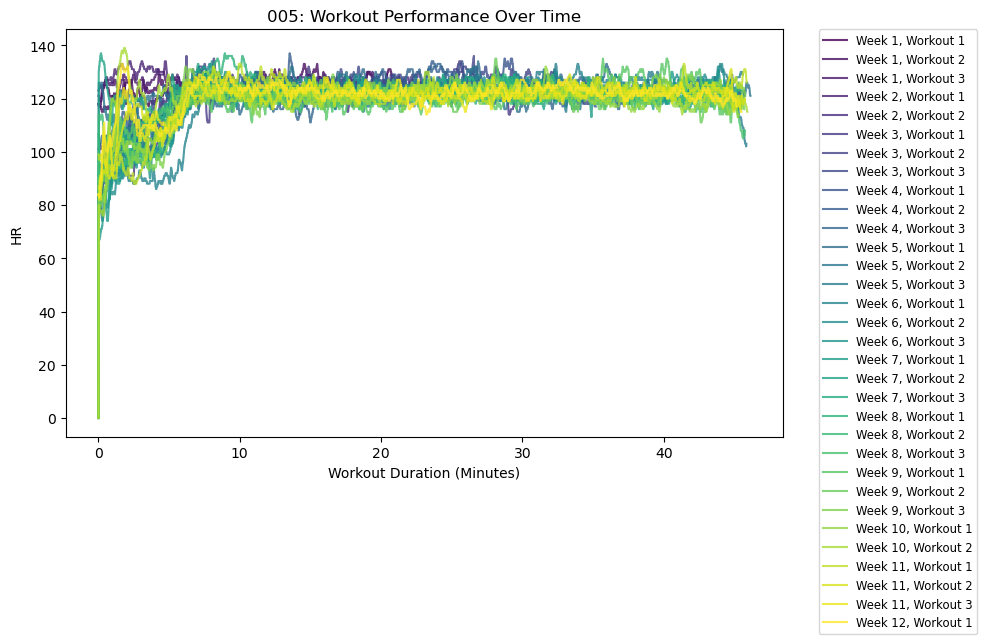

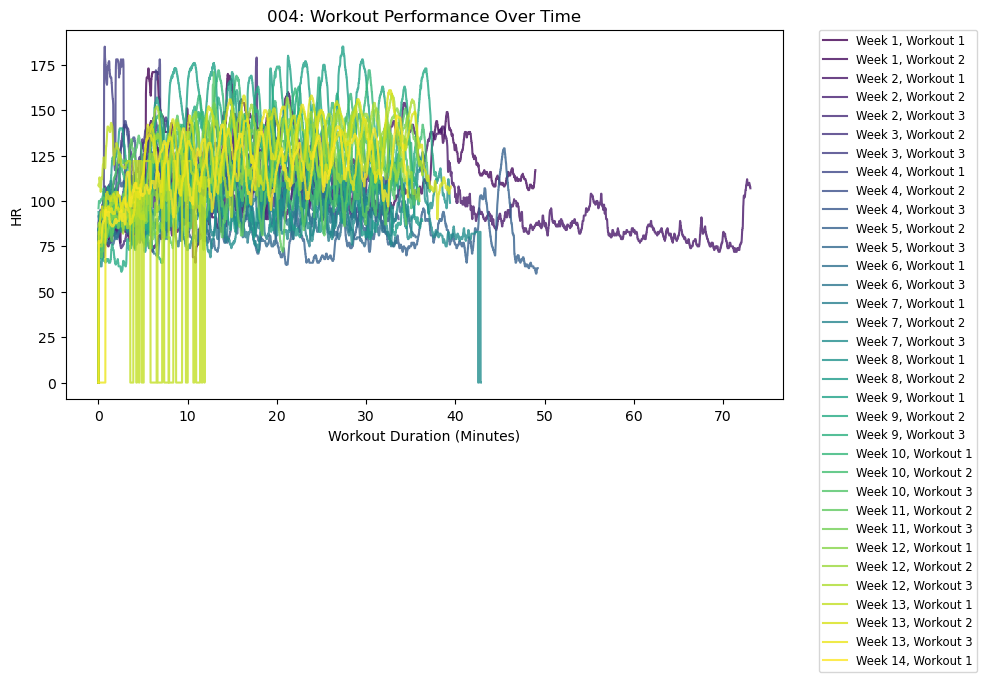

In [154]:
for i, (fid, df) in enumerate(workouts_dfs.items()):
    dfpptwos = preprocess(df)
    plot_workouts(dfpptwos)

rows: 4


/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/3587822971.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime_base'] = df.groupby(['wk_id', 'wo_id'])['_realtime'].transform('min')
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/3587822971.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_wotime'] = (df.loc[:,'_realtime'] - df.loc[:,'_wotime_base']).dt.total_seconds() / 60  # Here, we'll show time in minutes
/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000g

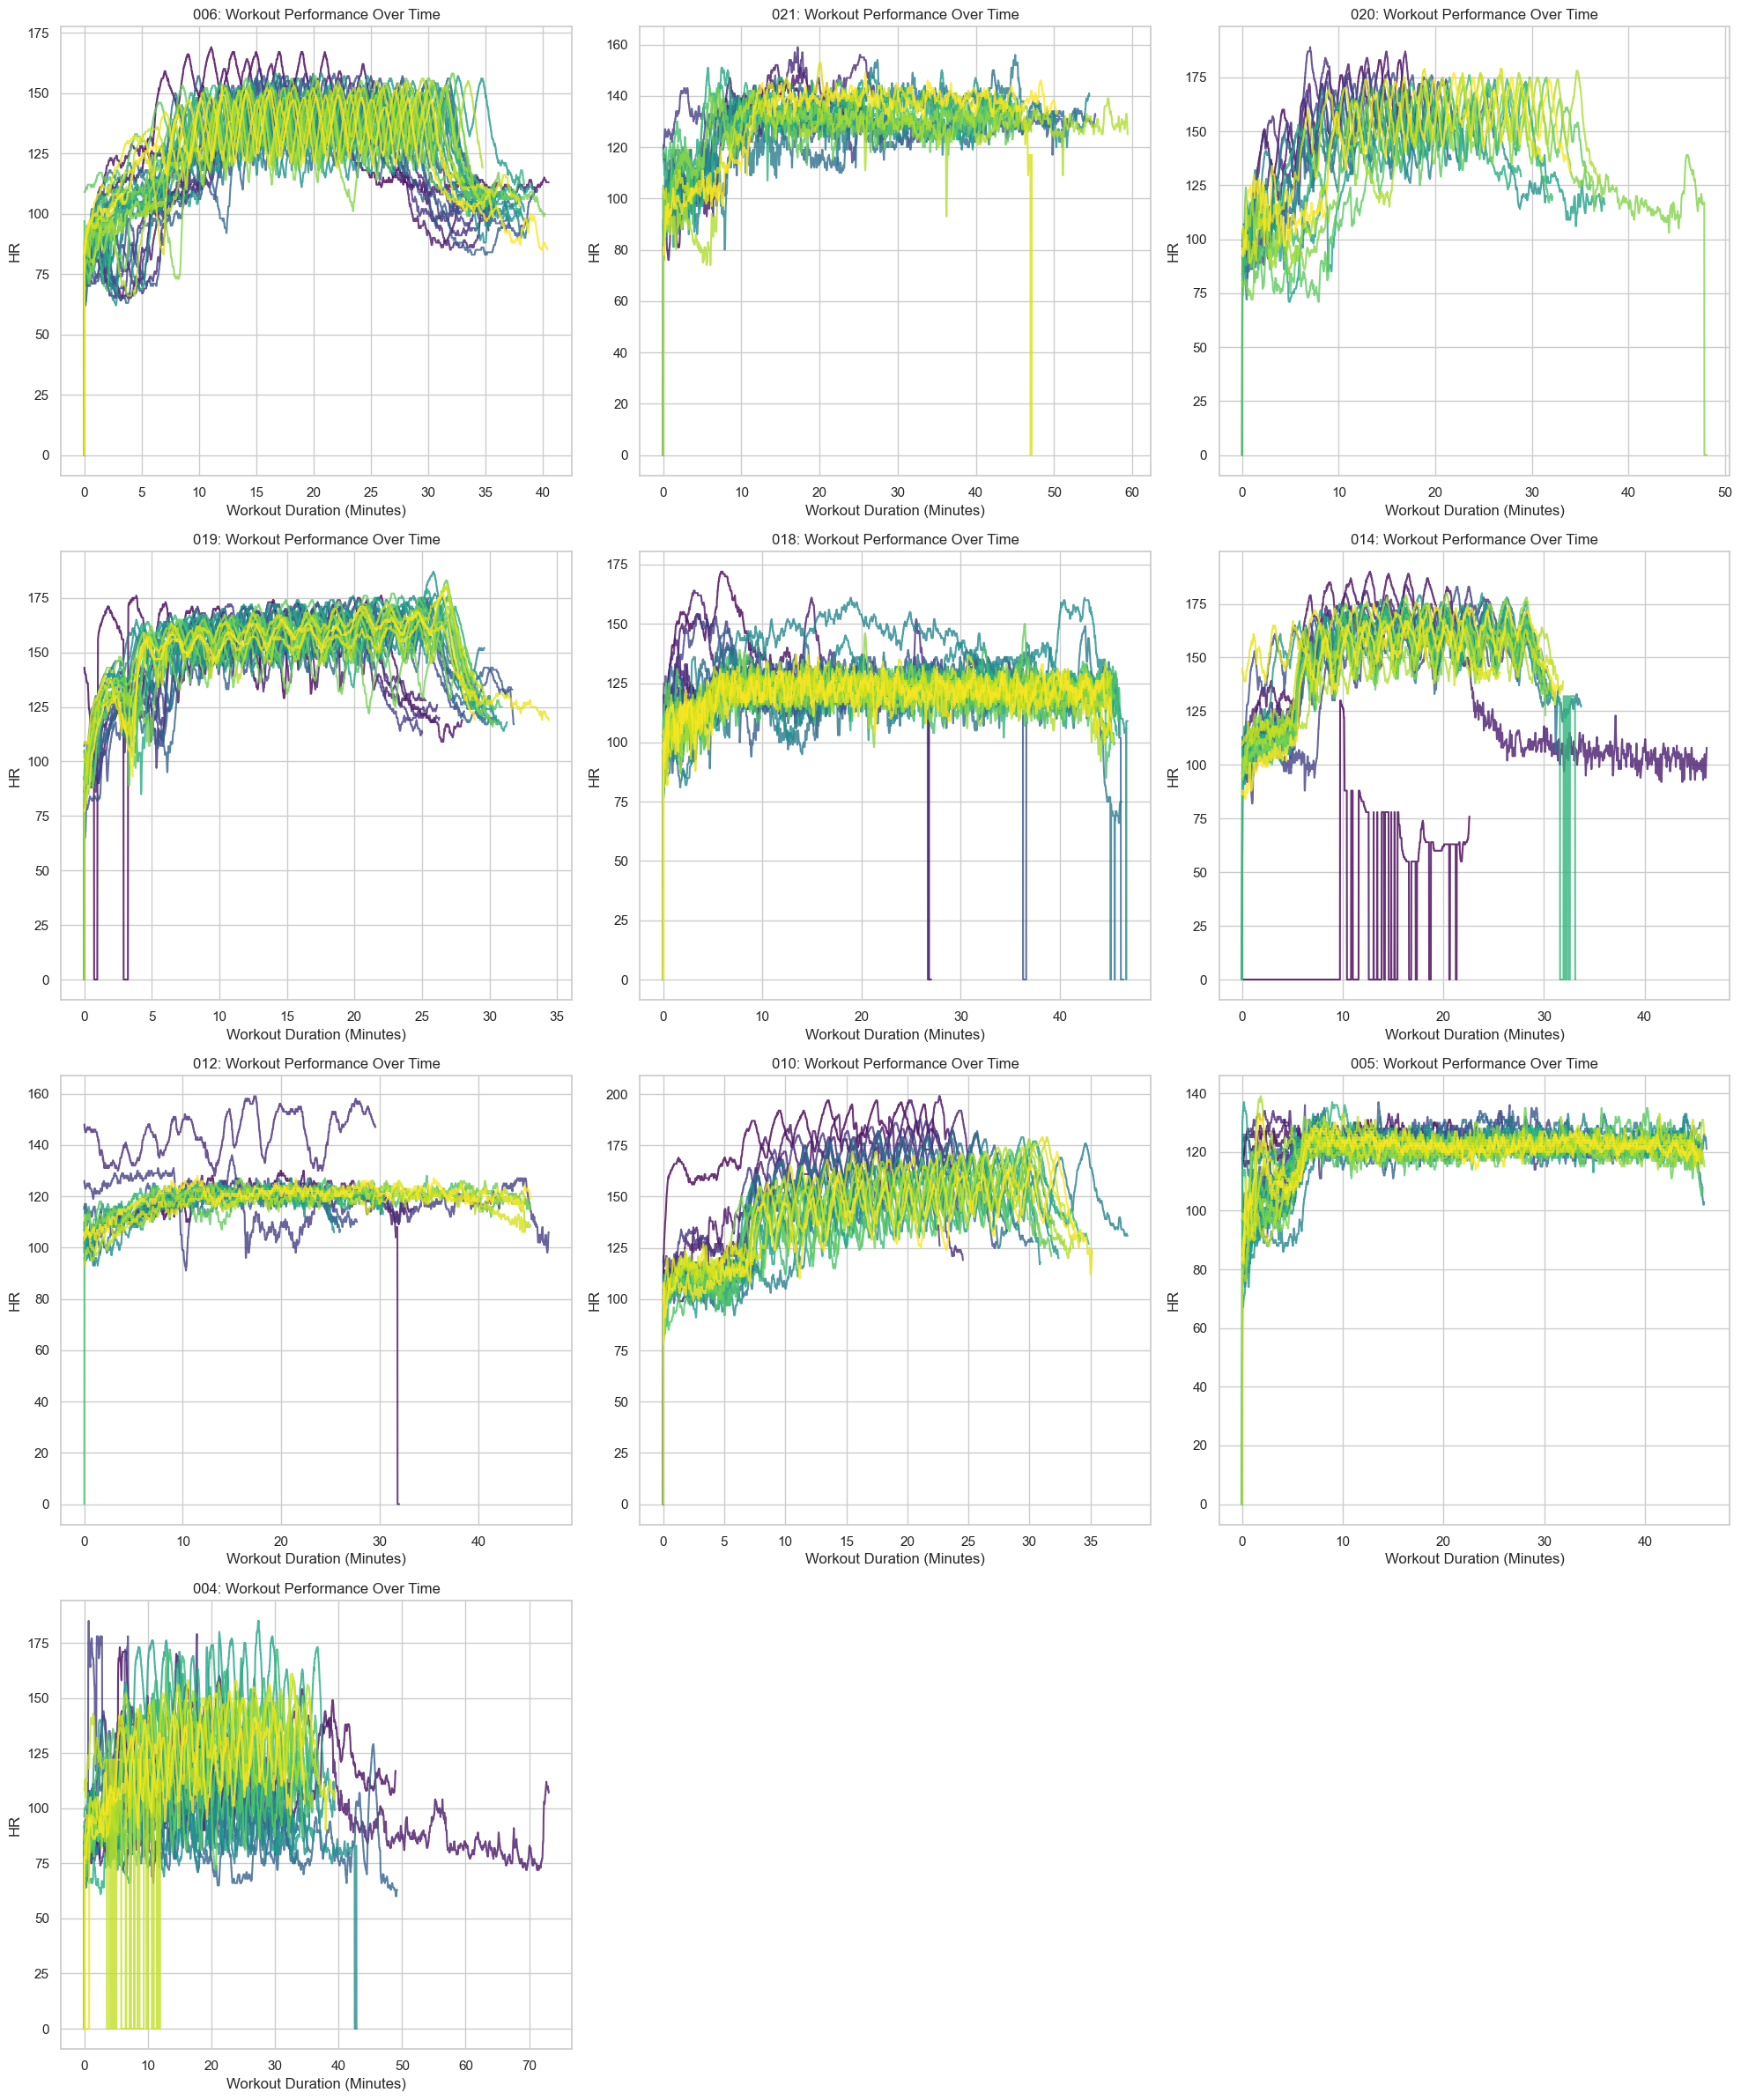

In [175]:
def plot_workouts_grid(df, ax):
    # Assuming ppt_id is a column in df
    ppt = df['ppt_id'].apply(lambda x: f'{x:03}')
    ppt = ppt.iloc[0]
    workouts = df.groupby(['wk_id', 'wo_id'])

    # Setup the color map
    n_colors = workouts.ngroups
    cmap = plt.get_cmap('viridis', n_colors) 

    for i, ((wk_id, wo_id), wo) in enumerate(workouts):
        ax.plot(wo['_wotime'], wo['value'], label=f'Week {wk_id}, Workout {wo_id}', color=cmap(i), alpha=0.8)
    
    ax.set_xlabel('Workout Duration (Minutes)')
    ax.set_ylabel('HR')
    ax.set_title(f'{ppt}: Workout Performance Over Time')
    # ax.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax.figure.tight_layout()

# Build plot grid
total_plots = len(workouts_dfs)
columns = 3
rows = (total_plots + 2) // columns  # Calculate rows needed, rounding up
print(f'rows: {rows}')
fig, axs = plt.subplots(rows, columns, figsize=(20, 6*rows))  # Adjust figsize as needed
fig.tight_layout(pad=3.0)  # Add space between plots

# Flatten the axs array if necessary
axs_flat = axs.flatten()

for i, (fid, df) in enumerate(workouts_dfs.items()):
    dfpptwos = preprocess(df)
    ax = axs_flat[i]
    plot_workouts_grid(dfpptwos, ax)  # Pass the specific Axes object to plot_workouts

# If the number of plots is odd, hide the last ax
if total_plots % columns:
    axs_flat[-1].axis('off')  # Hide the last subplot if unused
    axs_flat[-2].axis('off')  # Hide the last 2 subplot if unused

plt.show()

In [168]:
import seaborn as sns

def plot_workouts2(df):
    # Convert ppt_id to string with leading zeros and grab the first one for the title
    ppt = df['ppt_id'].apply(lambda x: f'{x:03}').iloc[0]

    # Creating a new 'label' column for the legend
    df['label'] = df.apply(lambda x: f'Week {x["wk_id"]}, Workout {x["wo_id"]}', axis=1)

    # Set the Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting using Seaborn lineplot for each workout over time
    # Seaborn handles grouping and coloring automatically
    sns.lineplot(data=df, x='_wotime', y='value', hue='label', palette='viridis', ax=ax, alpha=0.8)

    # Enhancing the plot
    ax.set_xlabel('Workout Duration (Minutes)')
    ax.set_ylabel('HR')
    ax.set_title(f'{ppt}: Workout Performance Over Time')

    # Adjusting the legend
    ax.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1), title='Workout')

    fig.tight_layout()

    # Display the figure without using plt.show() to be compatible with Jupyter notebooks and scripts
    plt.show()

/var/folders/yw/915p5y5n2z78t9tdv03lfh3r0000gq/T/ipykernel_61773/2626569463.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.apply(lambda x: f'Week {x["wk_id"]}, Workout {x["wo_id"]}', axis=1)


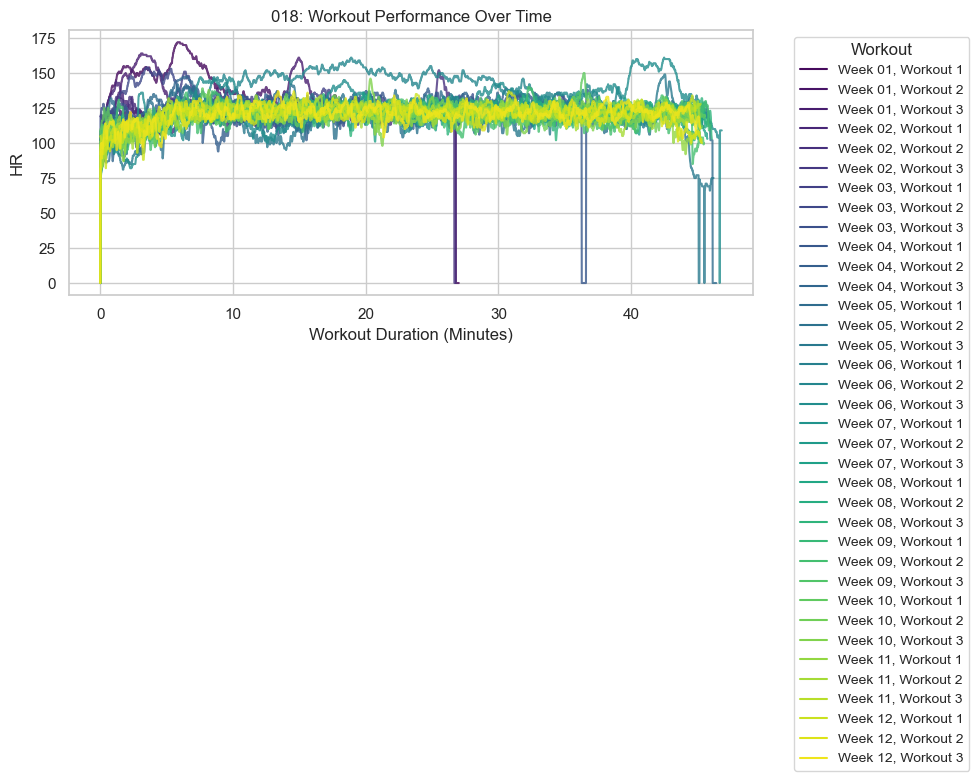

In [170]:
plot_workouts2(dftest_wotime)